### Work in Progress...

# Garments Production
This dataset includes important attributes of the garment manufacturing process and the productivity of the employees which had been collected manually and also been validated by the industry experts.

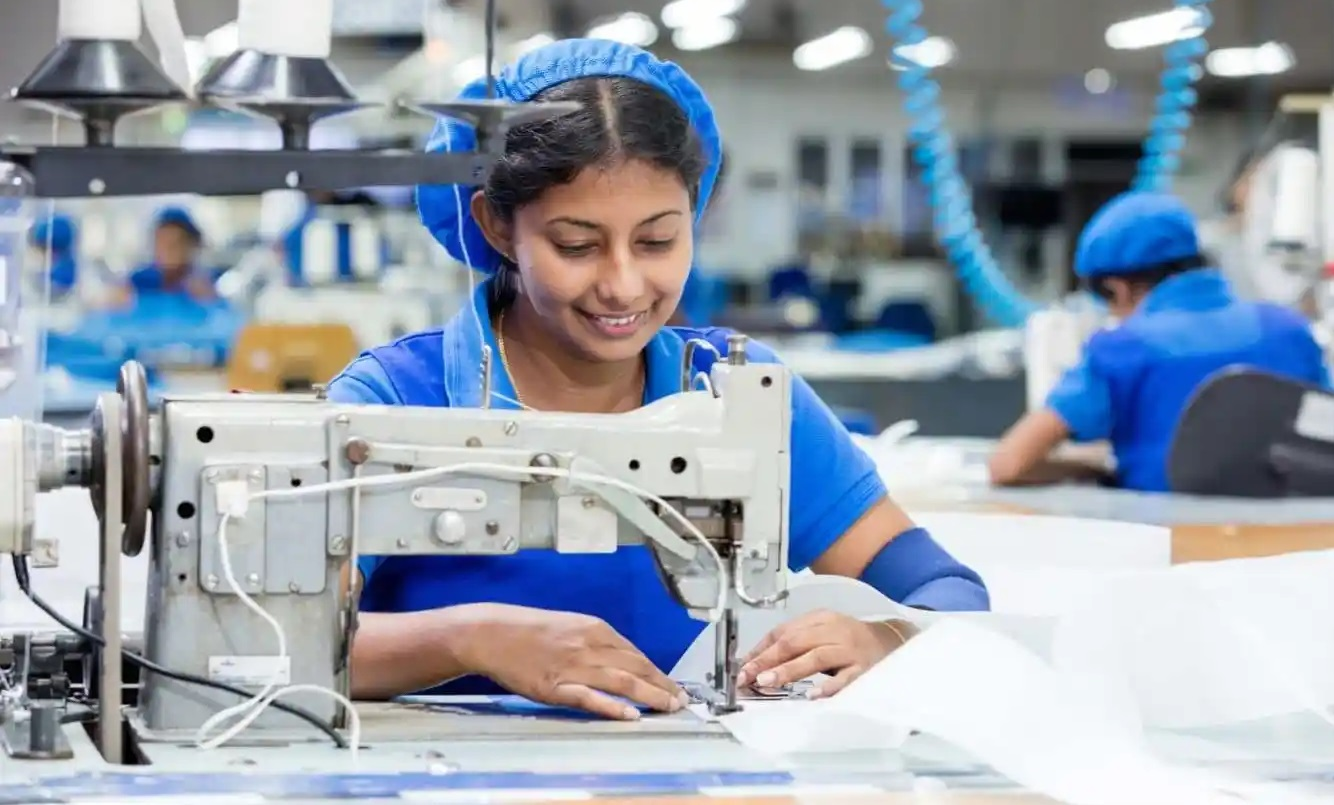

`Attribute Information:`

1. date : Date in MM-DD-YYYY
2. day : Day of the Week
3. quarter : A portion of the month. A month was divided into four quarters
4. department : Associated department with the instance
5. team : Associated team number with the instance
6. no_of_workers : Number of workers in each team
7. no_of_style_change : Number of changes in the style of a particular product
8. targeted_productivity : Targeted productivity set by the Authority for each team for each day.
9. smv : Standard Minute Value, it is the allocated time for a task
10. wip : Work in progress. Includes the number of unfinished items for products
11. overtime : Represents the amount of overtime by each team in minutes
12. incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
13. idletime : The amount of time when the production was interrupted due to several reasons
14. idlemen : The number of workers who were idle due to production interruption
15. actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.

# Load Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('garments_worker_productivity.csv')
print(df.shape)
df.head()

(1197, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


# EDA
Inspect, Clean, and Validate.
Show underlying patterns and relationships within datasets.

#### Dataset general information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

`task:`

Work in Progress... 

1. 
2. 
3. 

### Rename department column wrong typo's and convert to categorical dtypes

In [4]:
df.department.value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [5]:
df['department'] = df['department'].replace(['sweing'], 'sewing')
df['department'] = df['department'].replace(['finishing '], 'finishing')
df['department'] = df.department.astype('category')

df.department.value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

### Duplicates

In [6]:
# variable that store duplicates exactly the same as another row
dups = df.duplicated()
# count duplicates
dups.value_counts()

False    1197
dtype: int64

Theres no duplicates.

### Clean the Data (Null Values)

Check for the frequency of nulls in all the columns

In [7]:
df.isna().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

Theres a large proportion of null values in `wip`(42%). The first approach is to investigate how this data was collected or structured.

We need to undestand what type of missing data we are dealing:
- Structurally missing data
- Missing Completely at Random (MCAR)
- Missing at Random (MAR)
- Missing Not at Random (MNAR)

Check the shape of finishing and sewing department seperately.

In [8]:
finishing = df[df['department']=='finishing']
sewing = df[df['department']=='sewing']

print(finishing.shape)
sewing.shape

(506, 15)


(691, 15)

Check the total number of nulls in wip.

In [9]:
finishing.wip.isna().sum()

506

Nova! all of the NaN entries are comming from `finishing` department. What we need to so now is to ask and verify if there is really no pending works(wip) in the finishing department, just to be sure. Since there is no one to ask for this project I will conclude that this missing data is labeled as `Structurally Missing` thus there is no wip in the finishing department. 

Now were gonna impute these NaN values. We have a lot of techniques in imputing Nan's (ex. time series LOCF and NOCB, pairwise, listwise etc.) in this scenario we will convert these NaN in to zero.

In [10]:
# Converting wip NaN values to zero
df.wip.fillna(0, inplace=True)

#### Visualize the null datapoints

We convert first all nulls into 0 before plotting thats because matplot library does'nt read nulls so if we plot our variables without converting, null will not show in the plot. 

In [11]:
# Code preparation for plotting.
# Mapping departent to 0 and 1 as integer 
df['dept_mapped'] = df.department.map({
                                'finishing':0,
                                'sewing':1})
# convert to int dtype
df.dept_mapped  = df.dept_mapped.astype('int64')

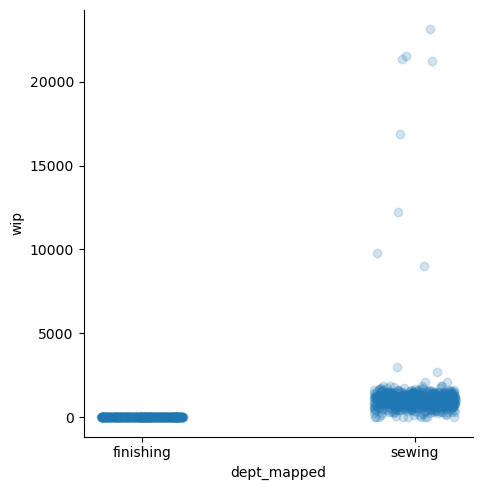

In [12]:
# plt.figure(figsize=(1, 1)) 
g = sns.lmplot(x='dept_mapped', y='wip', 
               data=df, 
               x_jitter=0.15, 
               y_jitter=0.15, 
               fit_reg=False, 
               scatter_kws={'alpha':0.2})

g.set(xticks=range(2))
g.set_xticklabels(['finishing', 'sewing'])
plt.show()

### Convert date to datetime dtype

In [13]:
# date format is MM-DD-YYYY
df['date'] = pd.to_datetime(df.date, format="%m/%d/%Y")

Augment data with additional columns(add month and work_week) 

In [14]:
# add month
df['month'] = df['date'].dt.month

In [15]:
# Adding `work_week` columns. It's easier to analyze production data per work week.
# create a list of our conditions
conditions = [
    
    #January
    (df['month'] == 1) & (df['quarter'] == 'Quarter1'), #ww1
    (df['month'] == 1) & (df['quarter'] == 'Quarter2'), #ww2
    (df['month'] == 1) & (df['quarter'] == 'Quarter3'), #ww3
    (df['month'] == 1) & (df['quarter'] == 'Quarter4'), #ww4
    (df['month'] == 1) & (df['quarter'] == 'Quarter5'), #ww4
    
    #February
    (df['month'] == 2) & (df['quarter'] == 'Quarter1'), #ww5
    (df['month'] == 2) & (df['quarter'] == 'Quarter2'), #ww6
    (df['month'] == 2) & (df['quarter'] == 'Quarter3'), #ww7
    (df['month'] == 2) & (df['quarter'] == 'Quarter4'), #ww8
    (df['month'] == 2) & (df['quarter'] == 'Quarter5'), #ww8
    
    #March
    (df['month'] == 3) & (df['quarter'] == 'Quarter1'), #ww9
    (df['month'] == 3) & (df['quarter'] == 'Quarter2'), #ww_10
    (df['month'] == 3) & (df['quarter'] == 'Quarter3'), #ww_11
    (df['month'] == 3) & (df['quarter'] == 'Quarter4'), #ww_12
    (df['month'] == 3) & (df['quarter'] == 'Quarter5'), #ww_12
    ]

values = ['ww1','ww2','ww3','ww4','ww4',
          'ww5','ww6','ww7','ww8','ww8',
          'ww9','ww_10','ww_11','ww_12','ww_12']

df['work_week'] = np.select(conditions, values)

### Quater column to categorical dtypes

In [16]:
quarter_order = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5' ]
df.quarter = pd.Categorical(df.quarter, quarter_order, ordered=True)
# verify quarter order
df.quarter.unique()

['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']
Categories (5, object): ['Quarter1' < 'Quarter2' < 'Quarter3' < 'Quarter4' < 'Quarter5']

###  Day column to categorical dtypes

In [17]:
df.day.unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [18]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday' ]
df.day = pd.Categorical(df.day, day_order, ordered=True)
# verify day order
df.day.unique()

['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
Categories (6, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Saturday' < 'Sunday']

### Inspect zero value (60% and up) 
Let's investigate this zero values.

In [19]:
# how many zeros are there in each columns?
# (df == 0).sum(axis=0) # uncomment to show result

print('Proportion of zeros: ')
(df == 0).sum(axis=0)  / len(df) * 100

Proportion of zeros: 


date                      0.000000
quarter                   0.000000
department                0.000000
day                       0.000000
team                      0.000000
targeted_productivity     0.000000
smv                       0.000000
wip                      42.272348
over_time                 2.589808
incentive                50.459482
idle_time                98.496241
idle_men                 98.496241
no_of_style_change       87.719298
no_of_workers             0.000000
actual_productivity       0.000000
dept_mapped              42.272348
month                     0.000000
work_week                 0.000000
dtype: float64

We have a very large proportion of zero value in `wip`, `incentive`, `idle_time`, `idle_men`,  and `no_of_style_change `.

- `wip ` This 42% of zeros are came from finishing department alternately the remaining 58% are work in progress by the sewing department.
- `incentive` 50% or half of the total production days got incentive
- `idle_time ` This large proportion is a good indication that the the production is running smoothly.
- `idle_men` Same as idle_time, most of the teams/workers are working deligently. 98% are zero value.
- `no_of_style_change ` 87.72% are zero values. Seems fair there is only 12% of change of product style that caused idle_time. Changing style might result to idle_time if not properly executed. 

# Statistical Analysis
After doing some cleaning and data wrangling, we can now plot the histogram of the dataset for inspection.

- Central Tendency
- Spread of quantitative variables



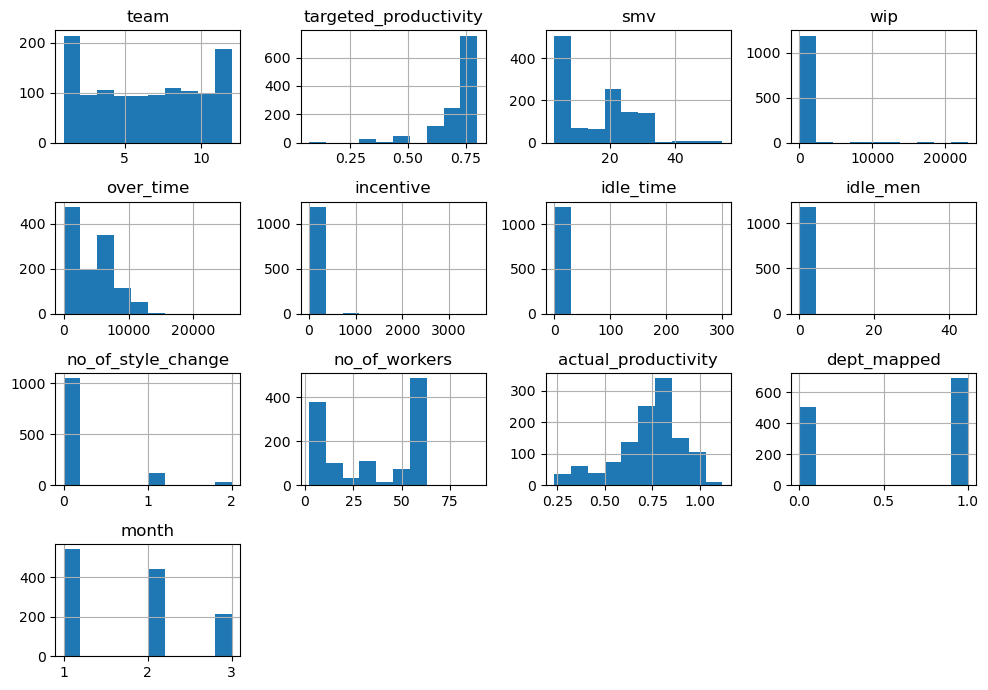

In [20]:
# we will not include date in this visualization
df.drop(columns=['date']).hist(figsize=(10, 7))
plt.tight_layout()
plt.show()

####  Skewness
Skewness is a measure of asymmetry of a distribution.
`Important Notes:`
-  between -0.5 and 0.5, fairly symmetrical
-  between -1 and -0.5 or between 0.5 and 1, moderately skewed
-  less than -1 or greater than 1,  highly skewed

In [21]:
# select numeric columns only
df_numeric = df.select_dtypes(include=np.number).columns.tolist()
for i in df_numeric:
    print(i + ' ==> ' + str(round(df[i].skew(),2)))

team ==> 0.01
targeted_productivity ==> -2.14
smv ==> 0.41
wip ==> 10.85
over_time ==> 0.67
incentive ==> 15.79
idle_time ==> 20.55
idle_men ==> 9.86
no_of_style_change ==> 2.94
no_of_workers ==> -0.11
actual_productivity ==> -0.81
dept_mapped ==> -0.31
month ==> 0.49


#### Kurtosis() 
kurtosis determines the heaviness of the distribution tails. Determine the volume of the outlier.
- If the distribution is tall and thin it is called a `leptokurtic` distribution(Kurtosis > 3). Values in a leptokurtic distribution are near the mean or at the extremes.
- A flat distribution where the values are moderately spread out is called `platykurtic`(Kurtosis <3) distribution.
- A distribution whose shape is in between a leptokurtic distribution and a platykurtic distribution is called a `mesokurtic`(Kurtosis=3) distribution. A mesokurtic distribution looks more close to a normal distribution.

'Note' 
1. High kurtosis in a df set is an indicator that df has heavy outliers.
2. Low kurtosis in a df set is an indicator that df has lack of outliers.

In [22]:
df.select_dtypes(include=np.number).kurt()

team                      -1.223906
targeted_productivity      5.613701
smv                       -0.795346
wip                      141.332609
over_time                  0.424364
incentive                299.032462
idle_time                442.638160
idle_men                 102.962869
no_of_style_change         8.181490
no_of_workers             -1.788108
actual_productivity        0.333227
dept_mapped               -1.905055
month                     -1.057430
dtype: float64

# 1. `team`
Fairly distributed and flat
   - Whats the best team so far?


`note:` Productivity is scaled from 0-1(0-100%)
- We will group the dataset by team then get the mean(avg) of it's productivity.

`Note` We will get the mean(avg) instead of median. Checking the shape of actual_prodcutivty we can see a moderately skew distribution(skewnew at -.81 kurtusis at .33). Unless it's heavily skew then we can use the median.

In [23]:
team = df.groupby('team').mean() # groupby then get the mean
team['diff_in_productivity'] = team.actual_productivity - team.targeted_productivity

# limit to 2 decimal places
team = team.round(2)

team[['targeted_productivity', 'actual_productivity', 'diff_in_productivity']]

,targeted_productivity,actual_productivity,diff_in_productivity
team,,,
1,0.75,0.82,0.07
2,0.74,0.77,0.03
3,0.74,0.80,0.06
4,0.72,0.77,0.05
5,0.67,0.70,0.02
6,0.73,0.69,-0.05
7,0.71,0.67,-0.05
8,0.71,0.67,-0.03
9,0.76,0.73,-0.02


Top 3 Productive Team

In [24]:
team.actual_productivity.sort_values(ascending=False).head(3)

team
1     0.82
3     0.80
12    0.78
Name: actual_productivity, dtype: float64

##### Visualization

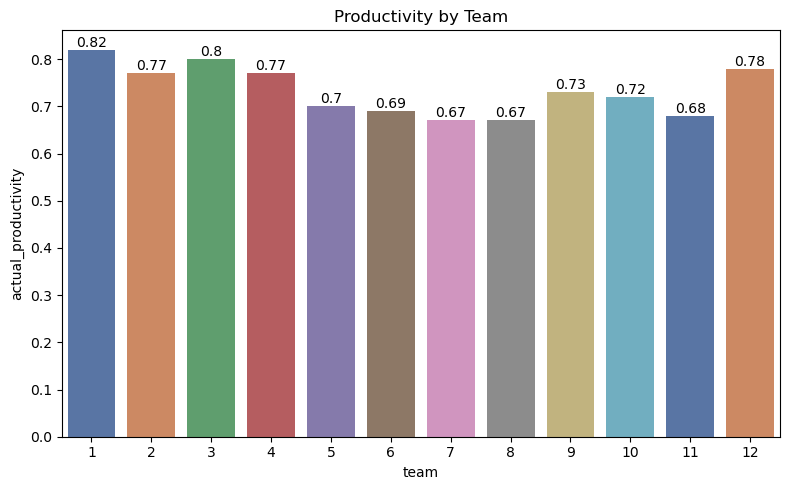

In [25]:
#
x = team.index
y = team.actual_productivity

plt.figure(figsize=(8,5))
ax1 = plt.subplot()
sns.barplot(x=x, y=y, palette = 'deep')
plt.title('Productivity by Team')

for i in ax1.containers:
    ax1.bar_label(i,)

plt.tight_layout()    
plt.show()

Team productivity by department

In [26]:
team_dept = df.groupby(['team','department']).mean() 
team_dept['diff_productivity'] = team_dept.actual_productivity - team_dept.targeted_productivity
team_dept = team_dept.round(2)

# Show first 3 teams
team_dept[['targeted_productivity', 'actual_productivity', 'diff_productivity']].head(6)

targeted_productivity  actual_productivity  diff_productivity
team department                                                               
1    finishing                    0.75                 0.83               0.08
     sewing                       0.74                 0.82               0.07
2    finishing                    0.75                 0.78               0.03
     sewing                       0.73                 0.76               0.03
3    finishing                    0.74                 0.85               0.11
     sewing                       0.74                 0.78               0.03

Visualization

In [27]:
# code preparation for visualization
team_act_prod = []
for i in team_dept.actual_productivity:
    team_act_prod.append(i)

sewing = team_act_prod[1::2]
finishing= team_act_prod[0::2]

# team_dept is a 2d list
# example code for accessing 2d indeces
# team 2 finishing dept would be:
# team_dept.actual_productivity[2][0]

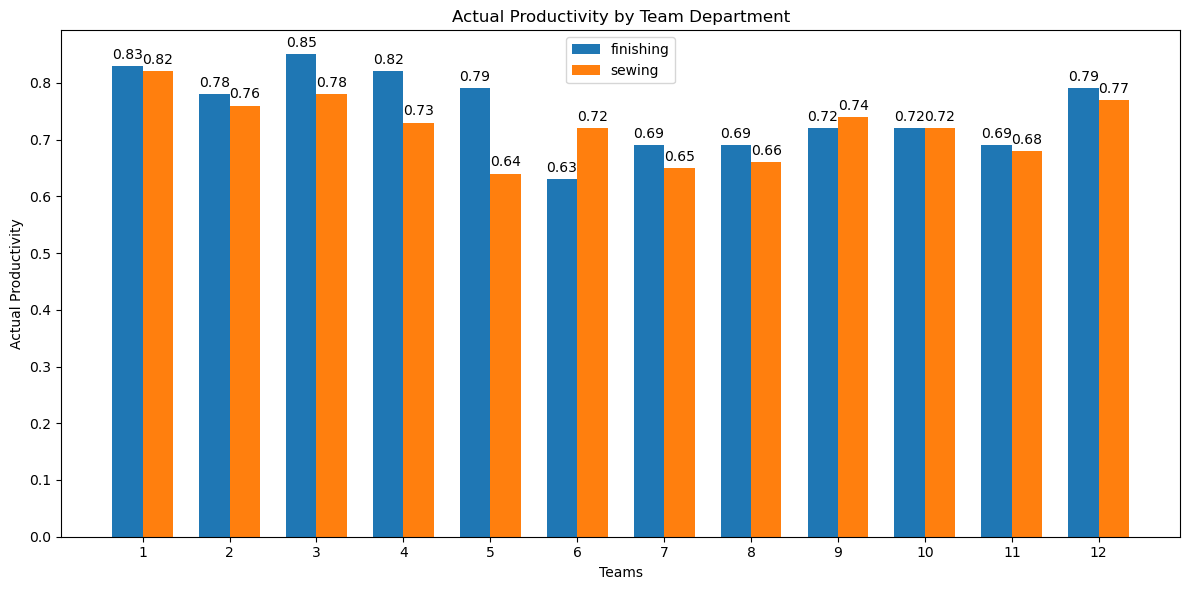

In [28]:
#
fig, ax = plt.subplots(figsize=(12,6))

x = np.arange(1,13)
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, finishing, width, label= 'finishing')
rects2 = ax.bar(x + width/2, sewing, width, label='sewing')
ax.set_xticks(x)
ax.set_xlabel('Teams')
ax.set_ylabel('Actual Productivity')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.title('Actual Productivity by Team Department')
autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.legend(loc='upper center')
plt.show()

# 2. `target productivity` 
Heavily left skewed. This is great, target productivy should have more high values.
   - Predicted vs. Actual Productivity

`Note` We group our dataset by work_week then we get the mean instead of median(we use median for heavily skew distribution). Checking the shape of its overall distribution(ww1-ww10) we can see a moderately skew shape(skewnew at -.81 kurtusis at .33). To be more precise we can check the distribution per work_week but I think that's not necessary here.

In [29]:
print('Average Productivity per work_week')
target_actual = df.groupby('work_week').mean()
target_actual[['targeted_productivity', 'actual_productivity']]

Average Productivity per work_week


,targeted_productivity,actual_productivity
work_week,,
ww1,0.774603,0.779225
ww2,0.746617,0.749937
ww3,0.715625,0.717431
ww4,0.704678,0.767010
ww5,0.737345,0.770341
ww6,0.723874,0.741566
ww7,0.727551,0.690275
ww8,0.729752,0.669766
ww9,0.718595,0.705212


Visualization

In [30]:
# setting variables
# target productivity average per workweek
tp_avg = df.groupby('work_week')['targeted_productivity'].mean()
# actual productivity average per workweek
ap_avg = df.groupby('work_week')['actual_productivity'].mean()

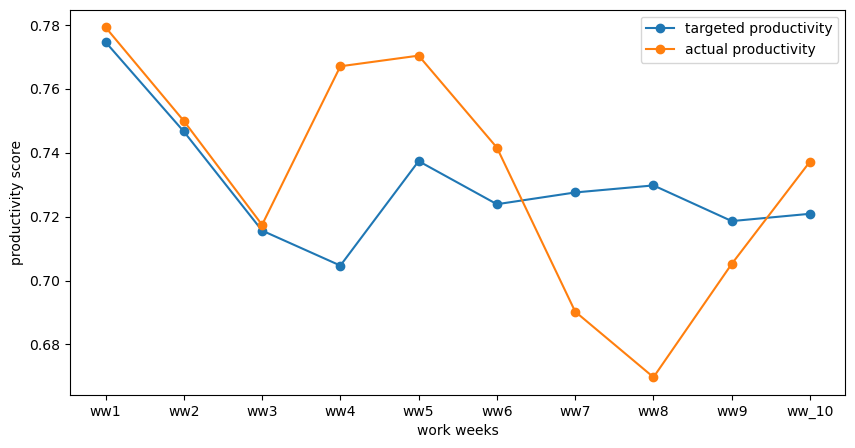

In [31]:
plt.figure(figsize=(10,5))

plt.plot(tp_avg.index, tp_avg, marker='o')
plt.plot(ap_avg.index, ap_avg, marker='o')

plt.xlabel('work weeks')
plt.ylabel('productivity score')
plt.legend(['targeted productivity', 'actual productivity'])

plt.show()

We have a very good ww4 and ww5 however after ww5 our productivity crashed to a very low level.

In [32]:
# Checking the reason behind the crash
idle = df.groupby('work_week').sum()
idle['idle_time']

work_week
ww1        0.0
ww2        0.0
ww3        0.0
ww4        0.0
ww5      810.0
ww6        0.0
ww7       38.0
ww8        8.0
ww9       18.0
ww_10      0.0
Name: idle_time, dtype: float64

We have a major downtime during ww5 that caused the fall of actual productivity.

# 3. `smv` 
Distribution is faily symmetrical

 - Check if theres variables correlated to smv(ex. Is low smv correlate to over_time?


In [33]:
def correlation_checker(col):
    plt.figure(figsize=(6, 6)) 
    corr_matrix = df.corr()
 
    corr_target = corr_matrix[[col]].drop(labels=[col])
    corr_target = corr_target.sort_values(by=[col], ascending=False)

    sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
    plt.show()

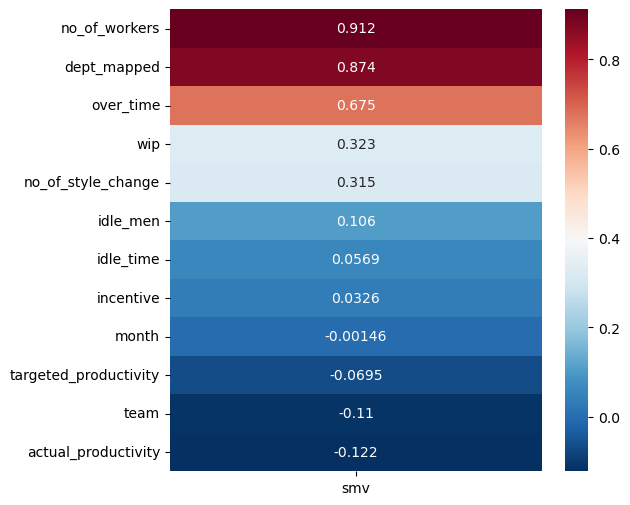

In [34]:
correlation_checker('smv')

There are three feature's that has high correlation to smv. However I'm more interested in no_of_workers and over_time, let's do scatter plot these features againts smv.

In [35]:
df_pairplot = df[['smv', 'no_of_workers', 'over_time' ]]

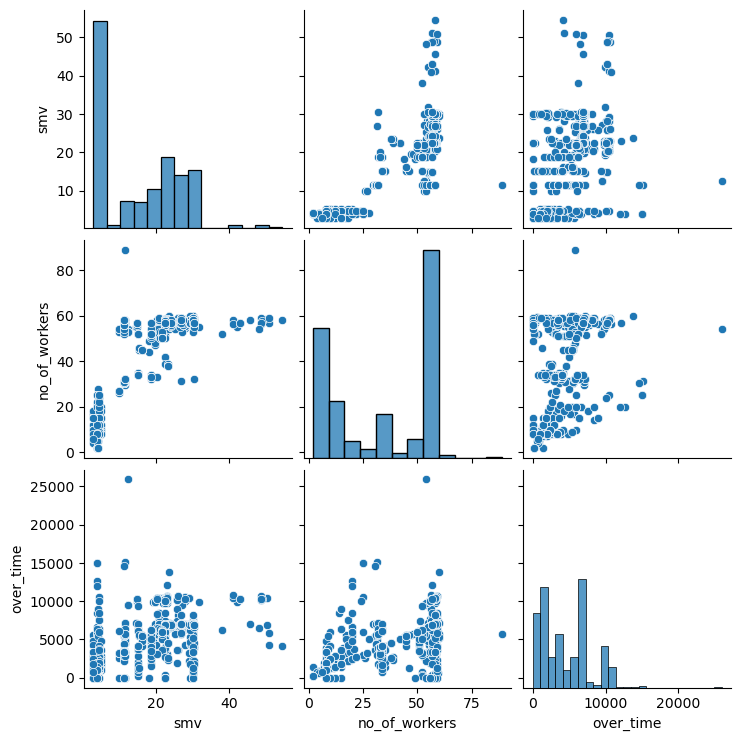

In [36]:
sns.pairplot(df_pairplot)
plt.show()

As smv(allocated time for a task) increase, the number of workers and overtime also increase. Increasing No_of_workers and over_time with respect to smv is to ensure that production will finish the task on time.

# 4. `wip` 
Heavily right skewed, as seen in above graph most of the datapoints are at zero and only few has value. Kurtosis at 110 indicating that the distribution is very tall(the mode has a very high proportion).

wip are task that does'nt finish yet, we can view this as delay. Let's check for what work_week has the most work in progress.

In [37]:
df_wip = df.groupby('work_week').sum()
df_wip['wip']

work_week
ww1       67385.0
ww2       66903.0
ww3       79075.0
ww4      114889.0
ww5      205579.0
ww6       61737.0
ww7       53760.0
ww8       65084.0
ww9       60416.0
ww_10     47784.0
Name: wip, dtype: float64

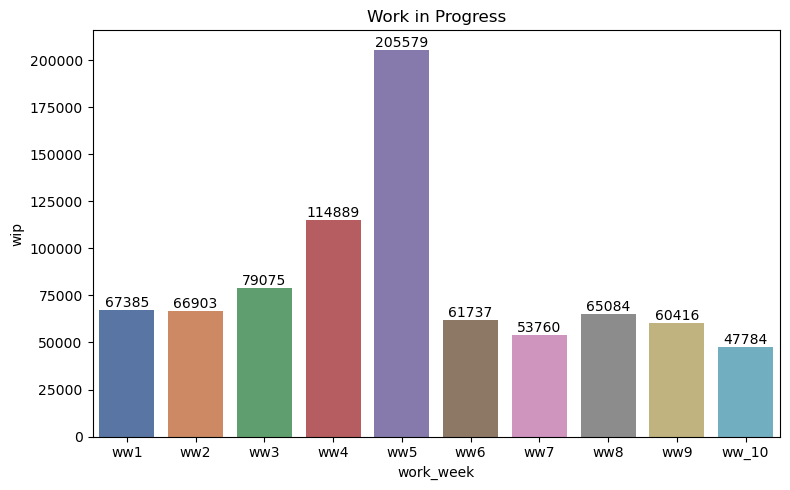

In [38]:
plt.figure(figsize=(8,5))
ax1 = plt.subplot()
sns.barplot(x= df_wip.index ,
            y= df_wip['wip'],
            palette = 'deep')

plt.title('Work in Progress')
for i in ax1.containers:
    ax1.bar_label(i,)

plt.tight_layout()    
plt.show()

We have a large work in progress last ww5. This is expected as we already see that there is a major idle_time(downtime) in ww5. Wonder what really happened in ww5.

# 5. `over_time` 
Moderately right skewed. Also a good sign, we must lessen OT while maintenaning high productivity.
   -  How much over_time does production have per work_week? Also the number of workers?



In [39]:
# set variables
ww = df.groupby('work_week').sum() # we use groupby then sum
ww['cummulative'] = ww.over_time.cumsum()
ww[['over_time', 'cummulative', 'no_of_workers']]

,over_time,cummulative,no_of_workers
work_week,,,
ww1,642450,642450,4304.5
ww2,777630,1420080,4303.5
ww3,722160,2142240,4216.0
ww4,895050,3037290,5720.5
ww5,479160,3516450,4182.0
ww6,370620,3887070,4155.0
ww7,306000,4193070,3436.5
ww8,471980,4665050,4210.0
ww9,491520,5156570,4057.0


- There are 642450 overtime minutes from work week1 with 4305 workers. An average of 2.48 OT hours per worker . (642450 / 4305 we will get 149 minutes then we divide by 60 to get 2.48 hours per worker)

##### Visualization
Over time per work week and it's cummulative value.

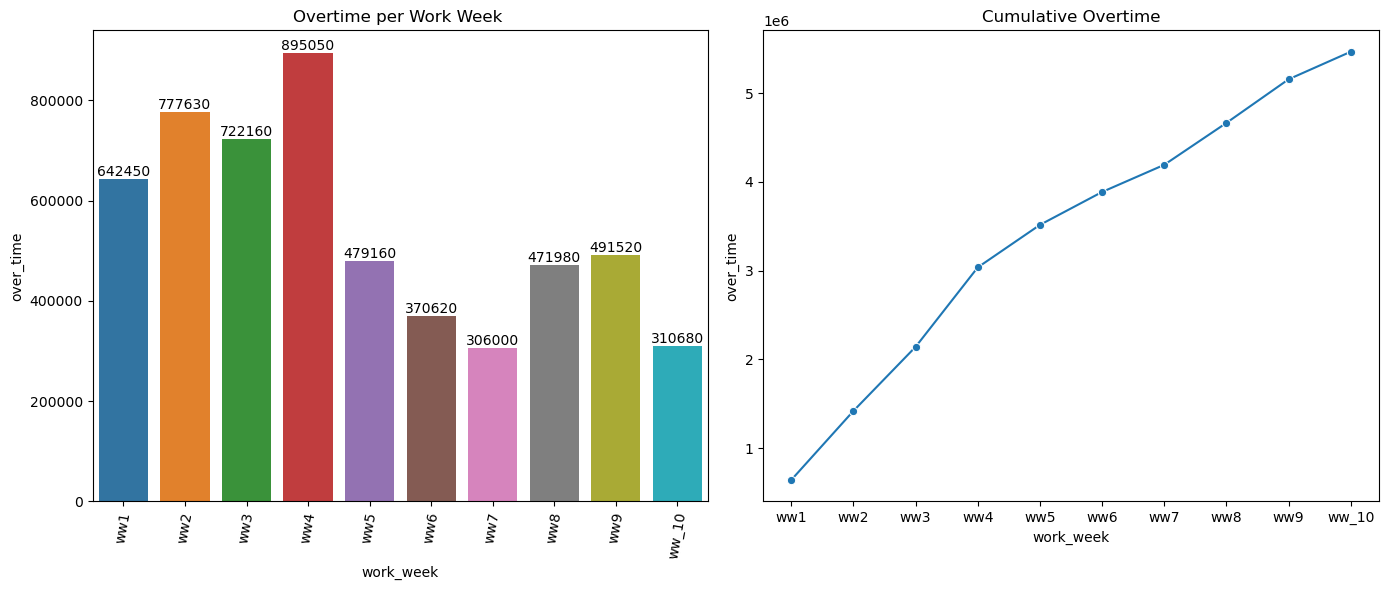

In [40]:
#
plt.figure(figsize=(14, 6)) 

# set variables
x = ww.index
y = ww.over_time

# plot1
# sum of overtime per work_week
ax1 = plt.subplot(1,2,1)
sns.barplot(x = x, y = y, data=df)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 80)
plt.title('Overtime per Work Week ')

for i in ax1.containers:
    ax1.bar_label(i,)


#plot2
# cumulative sum of work_week
ax2 = plt.subplot(1,2,2)
sns.lineplot(x=x, y=ww.over_time.cumsum(), marker='o', )
plt.title('Cumulative Overtime')

plt.tight_layout()
plt.show()

# 6. `incentive`
Heavily right skewed, most observation don't have incentives. Kurtosis at very high value(299) indicating that there is a large proportion of single observation(the zero value). 
   - Is this high value incentives has correlation with actual_productivy?
   - Take note, we should do an investigation with the outliers.

In [41]:
from scipy.stats import pearsonr
corr, p = pearsonr(df.incentive, df.actual_productivity)
corr, p

(0.07653762727386497, 0.008069571804677655)

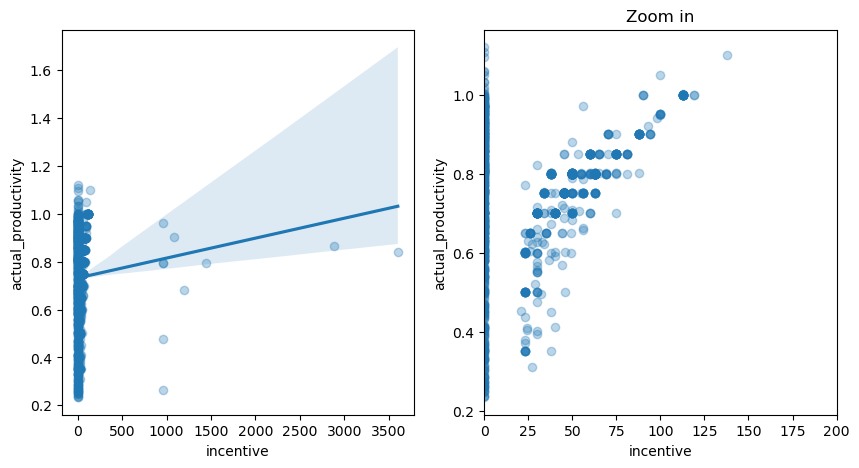

In [42]:
plt.figure(figsize=(10, 5)) 

ax1 = plt.subplot(1,2,1)
ax1 =  sns.regplot(x=df.incentive, y=df.actual_productivity, scatter_kws={'alpha':0.3})

# Zoom in 
ax2 = plt.subplot(1,2,2)
plt.title('Zoom in')
plt.scatter(df.incentive, df.actual_productivity, alpha=0.3)
plt.xlim(0,200)
plt.xlabel('incentive')
plt.ylabel('actual_productivity')

plt.show()

Most of the incentive that has value are from between 25 and 150, but how did we get a value of around 3500? Thats is for further investigation that we cant' solve in this given dataset. 

Without the outliers I think we can get a good correlation score.

`Follow up question:`
When this extremely high incentive happened?

In [70]:
# check details for this extreme incentives
df[df['incentive']>2500]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,dept_mapped,month,work_week
1130,2015-03-09,Quarter2,finishing,Monday,5,0.60,3.94,0.0,0,2880,0.0,0,0,12.0,0.864343,0,3,ww_10
1133,2015-03-09,Quarter2,finishing,Monday,9,0.75,2.90,0.0,0,3600,0.0,0,0,15.0,0.841000,0,3,ww_10


This extreme incentives happened on ww_10 particularly in the finishing department

In [71]:
ww10 = df[
          (df.work_week == 'ww_10') & 
          (df.day == 'Monday') &
          (df.department == 'finishing')
         ] 

ww10.sort_values(by='team')

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,dept_mapped,month,work_week
1139,2015-03-09,Quarter2,finishing,Monday,1,0.75,3.94,0.0,0,960,0.0,0,0,8.0,0.794567,0,3,ww_10
1143,2015-03-09,Quarter2,finishing,Monday,2,0.70,3.90,0.0,0,1200,0.0,0,0,10.0,0.682500,0,3,ww_10
1137,2015-03-09,Quarter2,finishing,Monday,3,0.80,4.60,0.0,0,1440,0.0,0,0,12.0,0.795417,0,3,ww_10
1138,2015-03-09,Quarter2,finishing,Monday,4,0.75,3.94,0.0,0,960,0.0,0,0,8.0,0.795388,0,3,ww_10
1130,2015-03-09,Quarter2,finishing,Monday,5,0.60,3.94,0.0,0,2880,0.0,0,0,12.0,0.864343,0,3,ww_10
1149,2015-03-09,Quarter2,finishing,Monday,8,0.65,3.90,0.0,0,960,0.0,0,0,8.0,0.264062,0,3,ww_10
1133,2015-03-09,Quarter2,finishing,Monday,9,0.75,2.90,0.0,0,3600,0.0,0,0,15.0,0.841000,0,3,ww_10
1148,2015-03-09,Quarter2,finishing,Monday,10,0.70,2.90,0.0,0,960,0.0,0,0,8.0,0.477292,0,3,ww_10
1128,2015-03-09,Quarter2,finishing,Monday,11,0.80,2.90,0.0,0,960,0.0,0,0,8.0,0.960625,0,3,ww_10
1129,2015-03-09,Quarter2,finishing,Monday,12,0.80,4.60,0.0,0,1080,0.0,0,0,9.0,0.902963,0,3,ww_10


Check the count of these said extreme incentives if equal to the number of teams who received incentive last ww10.

In [72]:
len(df[df['incentive']>500])

10

Choomss!! is there any special event in this day 2015-03-09, management are giving huge incentives.

# Perform Hypothesis Test

### Work in progress

# 7. `no_of_workers` 
Graph looks binomial, is there two group/kind/types of workers?


In [43]:
# import sklean library
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')

Check what features has strong correlation to no_of_workers.

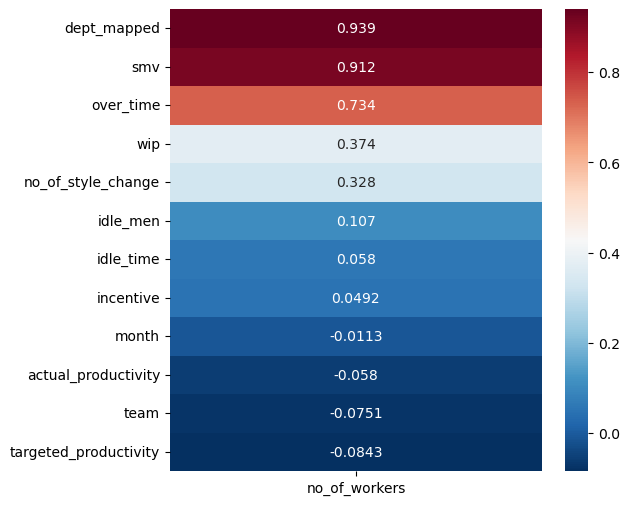

In [44]:
correlation_checker('no_of_workers')

In [45]:
# subset of our dataset
df_cluster = df[['no_of_workers', 'smv']]

# Normalise our data set
scaler = StandardScaler()
df_cluster = scaler.fit_transform(df_cluster)

 #### Finding the best `k` value 
 A good model is one with low inertia and a low number of clusters (K)

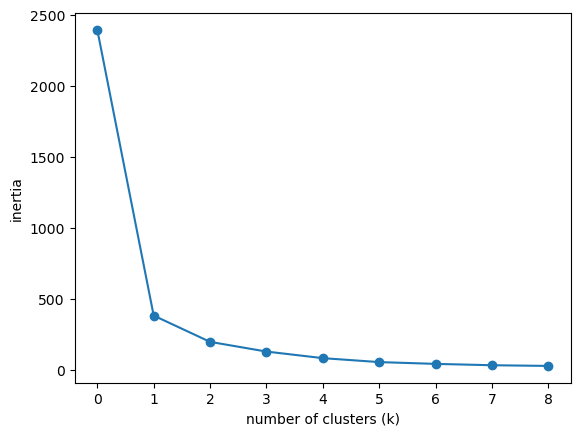

In [46]:
# hide/show code
clusters = []
inertias = []

# Checking what is the best 'k' value
# try for 9 
for k in range(1,10):
  km = KMeans(n_clusters=k, random_state=0)
  km.fit(df_cluster)
  
  # append clusters and inertias
  inertias.append(km.inertia_)
  clusters.append(km)
  
plt.plot(range(len(inertias)), inertias, '-o')
plt.xlabel('number of clusters (k)')
plt.ylabel('inertia')
plt.show()

#### Check for silhoutte score

In [47]:
for i in range(1,9,1): 
    print("---------------------------------------")
    print(clusters[i])
    print("Silhouette score:",silhouette_score(df_cluster, clusters[i].predict(df_cluster)))

---------------------------------------
KMeans(n_clusters=2, random_state=0)
Silhouette score: 0.7567741168682008
---------------------------------------
KMeans(n_clusters=3, random_state=0)
Silhouette score: 0.7015783380024647
---------------------------------------
KMeans(n_clusters=4, random_state=0)
Silhouette score: 0.6821538274382501
---------------------------------------
KMeans(n_clusters=5, random_state=0)
Silhouette score: 0.701341422245828
---------------------------------------
KMeans(n_clusters=6, random_state=0)
Silhouette score: 0.7306969976590627
---------------------------------------
KMeans(n_clusters=7, random_state=0)
Silhouette score: 0.6648649287636839
---------------------------------------
KMeans(random_state=0)
Silhouette score: 0.6699003925114578
---------------------------------------
KMeans(n_clusters=9, random_state=0)
Silhouette score: 0.6444164647470878


2 clusters seem pretty good. Let's apply clustering using k=2.

#### Kmeans with 2 clusters

In [48]:
km = KMeans(n_clusters=2, random_state=0)

# fit and predict labels
y_km = km.fit_predict(df_cluster)
y_km

array([0, 1, 1, ..., 1, 1, 1])

#### Assigning variables

In [49]:
# Note:
# first column is the no_of_workers
# 2nd column is the smv
df_cluster[0:5]

array([[ 1.0992288 ,  1.01455214],
       [-1.19926822, -1.01677766],
       [-0.18522542, -0.33387786],
       [-0.18522542, -0.33387786],
       [ 0.96402309,  0.99078321]])

In [50]:
no_of_workers = df_cluster[:,0]
smv = df_cluster[:,1]

# first 5 records
print(no_of_workers[0:5])
print(smv[0:5])

[ 1.0992288  -1.19926822 -0.18522542 -0.18522542  0.96402309]
[ 1.01455214 -1.01677766 -0.33387786 -0.33387786  0.99078321]


#### Setting up centroids
Center points of each clusters.

In [51]:
centers = km.cluster_centers_
centers

array([[ 0.8619967 ,  0.8127223 ],
       [-1.03123275, -0.9722843 ]])

#### Visualized

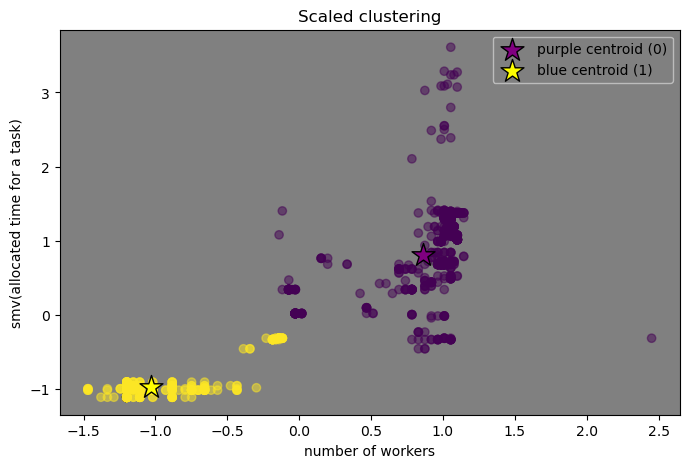

In [52]:
plt.rcParams['axes.facecolor'] = 'gray'

plt.figure(figsize=(8,5))
plt.scatter(no_of_workers, smv, c=y_km, alpha=0.5)

plt.scatter(centers[0][0], centers[0][1], marker='*', color ='purple', s=300, label ='purple centroid (0)', edgecolor = 'black')
plt.scatter(centers[1][0], centers[1][1], marker='*', color ='yellow', s=300, label ='blue centroid (1)', edgecolor = 'black')

plt.xlabel('number of workers')
plt.ylabel('smv(allocated time for a task)')
plt.legend()
plt.title('Scaled clustering')
plt.show()

Scatter plot again but this time we will revert back to un_scaled value

In [53]:
# turn our predicted value first into dataframe
group_worker = pd.DataFrame(y_km)

# concatenate, assign it to a new variable
df_new = pd.concat([df, group_worker], axis=1, join='inner')

# # rename column
df_new = df_new.rename(columns={0: 'group_worker'})

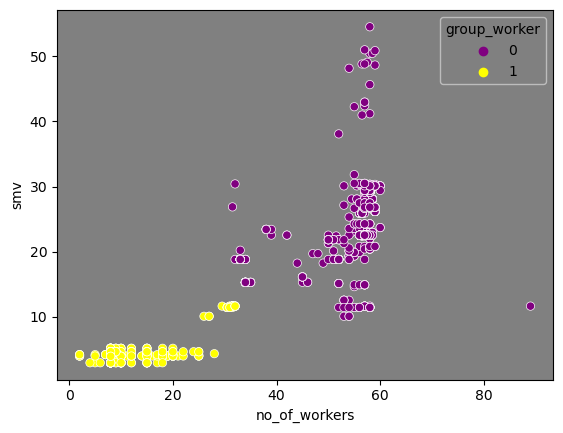

<function matplotlib.pyplot.clf()>

In [54]:
plt.rcParams['axes.facecolor'] = 'gray'

sns.scatterplot(x= 'no_of_workers', y= 'smv', data=df_new, hue='group_worker', palette=['purple','yellow'])
plt.show()
plt.clf

We can have two groups to choose from depending on smv value.
 
   - yellow = low number of worker needed
   - purple = more worker needed

1. `smv 0 to 10` =  (yellow, need up to 30 workers)
2. `smv 11 to 50` =  (purple, need 30 up to 60 workers)

# 8. no_of_style_change
Does no_of_style_change produce idle_time?

Frequency of unique value in no_of_style_change

In [55]:
df.no_of_style_change.value_counts()


0    1050
1     114
2      33
Name: no_of_style_change, dtype: int64

Proportion

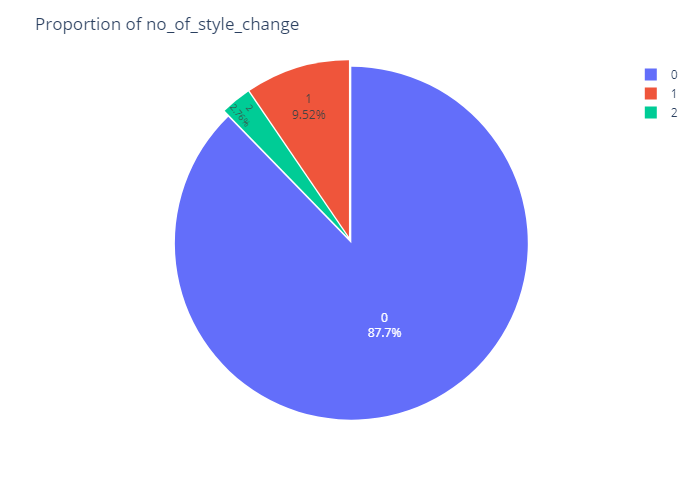

In [56]:
import plotly.express as px
fig = px.pie(df, 'no_of_style_change')

fig.update_layout(title="Proportion of no_of_style_change")
fig.update_traces(textposition='inside',
                  textinfo='percent+label', showlegend=True)

fig.update_traces(pull= 0.02)
fig.show('png')

Correlation between no_of_style_change and idle_time.

In [57]:
from scipy.stats import pearsonr
corr, p = pearsonr(df.no_of_style_change, df.idle_time)
corr, p

(-0.011597866663013127, 0.6885278961213044)

There's no significant correlation between no_of_style_change and idle_time. Also the pval is at very high value.

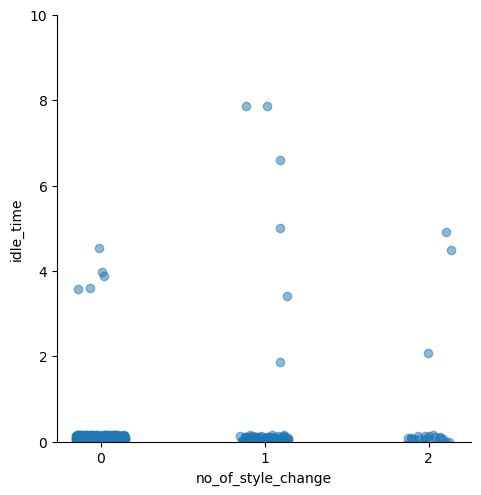

In [58]:
# visualize
plt.rcParams['axes.facecolor'] = 'white'
g = sns.lmplot(x='no_of_style_change', y='idle_time', 
               data=df, 
               x_jitter=0.15, 
               y_jitter=0.15, 
               fit_reg=False, 
               scatter_kws={'alpha':0.5})

g.set(xticks=range(3))
g.set_xticklabels(df.no_of_style_change.unique())
g.set(ylim=(0,10))
plt.show()

- There are 147(12.28%) total number change in production
- Changing style can cause idle time up to 8 minutes. 

How many idle_time does the production had that cause 2-8 minutes?

In [59]:
change_style_idle = df[df['idle_time']>=2]

# we use count because we need to determine how many idle_time does the production had that is >= 2
change_style_idle.groupby('no_of_style_change').count()[['idle_time']]

,idle_time
no_of_style_change,
0,9
1,6
2,3


We will not include the 0 change style hence we have a total of 9 idle_time that are greater that 2 minutes

Proportion

In [60]:
9/len(df)

0.007518796992481203

Almost 0% downtime from changing style. The production manage their change in style seamlessly.

# 10. Prodcutivity per month

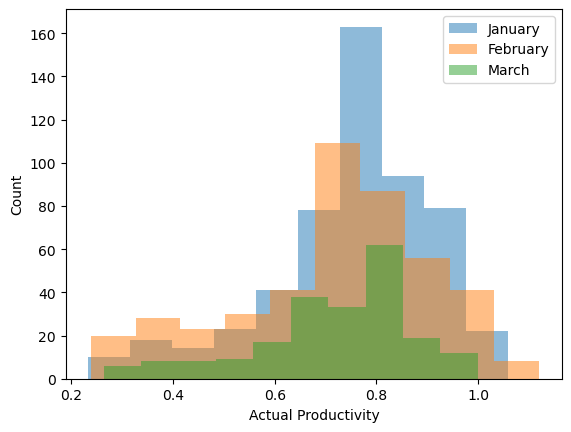

In [61]:
jan = df[df['month']==1]
feb = df[df['month']==2]
mar = df[df['month']==3]

plt.hist(jan.actual_productivity, alpha=.5, label='January')
plt.hist(feb.actual_productivity, alpha=.5, label='February')
plt.hist(mar.actual_productivity, alpha=.5, label='March')

plt.xlabel('Actual Productivity')
plt.ylabel('Count')
plt.legend()
plt.show()

We have a very good productivy last January.

`Note`: There are records of productivy higher than 1. (we assumed that productivity are scaled from 0-1)

In [62]:
feb_higher_prod = feb[feb.actual_productivity >1][['actual_productivity']]
print(len(feb_higher_prod))
feb_higher_prod.sort_values(by='actual_productivity', ascending=False).head(3)

28


,actual_productivity
766,1.120437
767,1.108125
730,1.100484


There are 28 entries of productivity score higher that our intended max value(1). Is this a typo error or system error? We will leave this question for now.

# EDA prior Machine Learning
## Work in progress...



## Outliers

In [63]:
#define functions
def showoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        
        # lower whisker
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5 
        # upper whisker
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        
        # dfpoints beyond lower whisker
        lowerbound_outliers = df[df[column_name] < lowerbound]
        
        # adtapoint beyond upper whisker
        higherbound_outliers = df[df[column_name] > upperbound]
        
        # outliers
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        return outliers
    
def countoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        count = len(outliers)
        return {column_name : count}
    
def Replace_Outliers(df_name, value, column_name = ""):
    iqr = df_name[column_name].quantile(.75) - df_name[column_name].quantile(.25)
    
    lowerbound = (df_name[column_name].quantile(.25)) - iqr * 1.5
    upperbound = (df_name[column_name].quantile(.75)) + iqr * 1.5
            
    df_name[column_name] = np.where(df_name[column_name] > upperbound, value, df_name[column_name])
    df_name[column_name] = np.where(df_name[column_name] < lowerbound, value, df_name[column_name])

Create a dataset with only numeric values

In [64]:
# selected features only
df_n = df[[ 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'no_of_workers', 'actual_productivity']]
# df_n

Count outliers

In [65]:
column_list = df_n.columns
column_list = np.array(column_list)
for i in df_n:
    print (countoutliers(df_n, i))

{'targeted_productivity': 79}
{'smv': 0}
{'wip': 9}
{'over_time': 1}
{'incentive': 11}
{'no_of_workers': 0}
{'actual_productivity': 54}


Proportion outliers

In [66]:
for i in column_list:
    col = i
    perc = countoutliers(df_n, i)[i] / len(df_n)
    print (col + ': ' + str('{:.2f}'.format(perc*100)) + '%') 

targeted_productivity: 6.60%
smv: 0.00%
wip: 0.75%
over_time: 0.08%
incentive: 0.92%
no_of_workers: 0.00%
actual_productivity: 4.51%


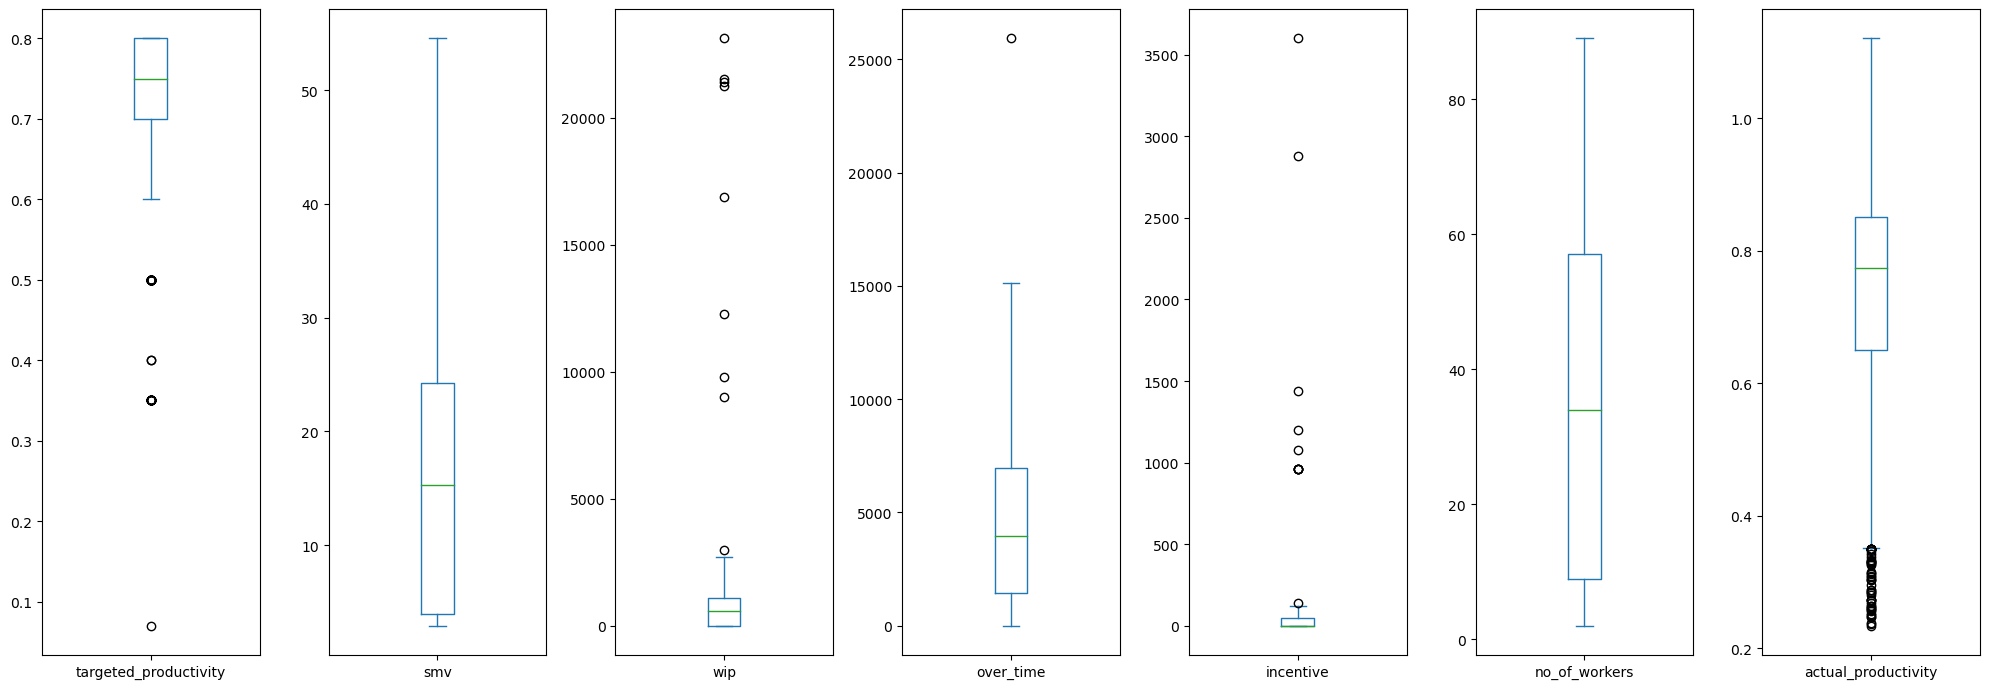

In [67]:
df_n.plot(kind='box', 
          subplots=True, 
          sharey=False, 
          figsize=(20, 7))
# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 

plt.tight_layout()
plt.show()

There's one columns that cought my attention. The 'Incentive', it has the most skewed and has high kurtosis values. Let's focus on these and do some imputations. 

Replace outliers with 75 percentile of the distribution

In [68]:
df_new.incentive.describe()

count    1197.000000
mean       38.210526
std       160.182643
min         0.000000
25%         0.000000
50%         0.000000
75%        50.000000
max      3600.000000
Name: incentive, dtype: float64

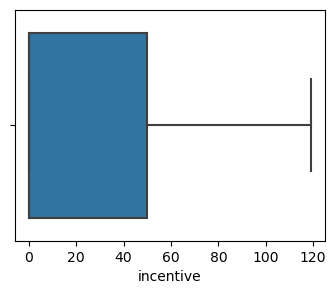

In [69]:
Replace_Outliers(df_new, 50, 'incentive')

# visualize
plt.figure(figsize=(4,3))
sns.boxplot(x='incentive', data=df_new)
plt.show()